## 0. Setup

In [24]:
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [25]:
import requests
import pandas
from re import sub
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import numpy as np
import concurrent.futures

## 1. Utility functions and constants

In [26]:
API_URL = "https://akasha.cv/api/leaderboards"
INFINITY = float("inf")
MAX_PAGES = 1000  # 1000 pages * 20 entries per page = 20_000 entries


In [27]:
def snake_case(s):
    """
    Utility function to convert a string to 'this_format'
    """
    return "_".join(
        sub("([A-Z][a-z]+)", r" \1",
            sub("([A-Z]+)", r" \1",
                s.replace("-", " "))).split()).lower()


## 2. Fetch the data from Akasha.cv API

In [28]:
def get_akasha_lb(calculation_id, variant="", lower_bound=INFINITY):
    """
    Gets a single page from the Akasha.cv API for the given calculation id and variant,
    applying the given lower bound constraint to the results.
    """
    params = {
        "sort": "calculation.result",
        "order": -1,
        "p": "lt|" + ("Infinity" if lower_bound == INFINITY else str(lower_bound)),
        "calculationId": calculation_id,
        "variant": variant
    }
    req = requests.get(API_URL, params)
    data = req.json()

    ## Insert the variant into the data
    for entry in data["data"]:
        entry["variant"] = variant

    return data["data"]


In [29]:
def get_akasha(calculation_id, variant="", max=100):
    """
    Gets the data from the Akasha.cv API for the given calculation id and variant,
    with a maximum number of pages.
    """

    results = []

    lb = INFINITY
    for _ in tqdm(range(max)):
        page = get_akasha_lb(calculation_id, variant, lb)
        if len(page) == 0:
            break

        for p in page:
            results.append(p)
        lb = page[-1]["calculation"]["result"]

    return results


## 3. Transform the JSON data into a DataFrame

In [30]:
def normalize_akasha_data_row(json):
    """
    Convert a row of the Akasha.cv API response to a flat dictionary
    """
    def get_mainstat(name):
        name = json["artifactObjects"][name]["mainStatKey"] \
            if name in json["artifactObjects"] \
            else None
        return snake_case(name) if name else None

    def get_set(n_piece, index=0):
        """
        Get the n_piece-piece set
        """
        i = 0

        for set_name in json["artifactSets"]:
            set_count = json["artifactSets"][set_name]["count"]
            if set_count == n_piece:
                if i == index:
                    return snake_case(set_name)
                i += 1

        return None

    def get_stats():
        dict = {}
        for stat in json["stats"]:
            dict[snake_case(stat)] = json["stats"][stat]["value"]
        return dict

    flat = {
        "uid": json["uid"],
        "name": snake_case(json["name"]),
        "player": json["owner"]["nickname"],
        "calculation_id": json["calculation"]["id"],
        "variant": json["variant"],
        "calculation_result": json["calculation"]["result"],
        "crit_value": json["critValue"],
        "sands": get_mainstat("EQUIP_SHOES"),
        "goblet": get_mainstat("EQUIP_RING"),
        "circlet": get_mainstat("EQUIP_DRESS"),
        "real_weapon": snake_case(json["weapon"]["name"]),
        "set_2_1": get_set(2),
        "set_2_2": get_set(2, 1),
        "set_4": get_set(4),
        "stats": get_stats()
    }
    return flat


In [31]:
def normalize_akasha_data(data):
    """
    Convert the Akasha.cv API response to a flat dictionary
    """
    dfs = []
    for row in tqdm(data):
        flat = normalize_akasha_data_row(row)
        flat = pandas.json_normalize(flat)
        dfs.append(flat)
    
    df = pandas.concat(dfs, ignore_index=True)
    return df


## 4. Get the data

In [32]:
raw_data_requests = [
    ("1000003300"), # Tartaglia - Childe International, Avg DMG (Polar)
    ("1000002300"), # Xiangling - National Pyronado Vape Avg DMG (The Catch)
    ("1000002300", "200er"), # Xiangling - National Pyronado Vape Avg DMG (The Catch)
    ("1000005200"), # Shogun Raiden - Hyper Raiden Burst, Avg DMG (Engulfing Lightning)
    ("1000006000", "190er"), # Yelan - Exquisite Throw Double Hydro, Avg. DMG (Elegy)
    ("1000006001", "190er"), # Yelan - Exquisite Throw Double Hydro, Avg. DMG (Aqua)
    ("1000004601", "not-shimenawa"), # Hu Tao - 11N1CD + Q, Xingqiu/Yelan/Zhongli, Avg. DMG (Homa)
]

In [33]:
def get_akasha_with_args(args):
    if type(args) != tuple:
        args = (args,)
        
    if len(args) == 1:
        return get_akasha(args[0], max=MAX_PAGES)
    elif len(args) == 2:
        return get_akasha(args[0], args[1], max=MAX_PAGES)

In [34]:
raw_data = []

with concurrent.futures.ThreadPoolExecutor(max_workers=12) as executor:
    raw_data = executor.map(get_akasha_with_args, raw_data_requests)

  0%|          | 0/1000 [00:00<?, ?it/s]

















  0%|          | 1/1000 [00:00<12:15,  1.36it/s]














  0%|          | 2/1000 [00:01<08:27,  1.96it/s]











  0%|          | 3/1000 [00:01<07:22,  2.26it/s]














  0%|          | 4/1000 [00:01<06:32,  2.54it/s]














  0%|          | 5/1000 [00:02<06:12,  2.67it/s]














  1%|          | 6/1000 [00:02<05:55,  2.79it/s]














  1%|          | 7/1000 [00:02<05:49,  2.84it/s]














  1%|          | 8/1000 [00:03<05:43,  2.89it/s]














  1%|          | 9/1000 [00:03<05:44,  2.87it/s]









  1%|          | 10/1000 [00:03<05:43,  2.88it/s]














  1%|          | 11/1000 [00:04<05:40,  2.90it/s]













  1%|          | 12/1000 [00:04<05:40,  2.90it/s]















  1%|▏         | 13/1000 [00:04<05:37,  2.92it/s]














  1%|▏         | 14/1000 [00:05<05:46,  2.84it/s]














  2%|▏         | 15/1000 [00:05<05:48,  2.83it/s]















In [35]:
_raw_data = []
for row in raw_data:
    for r in row:
        _raw_data.append(r)
raw_data = _raw_data
raw_data

[{'_id': '64eccacedbe6a10bf2f3f2c4',
  'calculation': {'id': '1000003300', 'result': 687599.1708558884},
  'characterId': 10000033,
  'type': 'current',
  'uid': '714513517',
  'artifactObjects': {'EQUIP_SHOES': {'mainStatKey': 'ATK%'},
   'EQUIP_RING': {'mainStatKey': 'Hydro DMG Bonus'},
   'EQUIP_DRESS': {'mainStatKey': 'Crit DMG'}},
  'artifactSets': {"Nymph's Dream": {'icon': 'https://enka.network/ui/UI_RelicIcon_15029_4.png',
    'count': 4},
   'Noblesse Oblige': {'icon': 'https://enka.network/ui/UI_RelicIcon_15007_4.png',
    'count': 1}},
  'calculations': {},
  'constellation': 3,
  'costumeId': '',
  'critValue': 269.7699980316442,
  'md5': '84d046feb6385852f36f5df2d9aa5926',
  'name': 'Tartaglia',
  'owner': {'nickname': 'Уильям',
   'adventureRank': 60,
   'profilePicture': 10000033,
   'nameCard': 'UI_NameCardPic_Ysxf4_P',
   'patreon': {},
   'region': 'EU'},
  'propMap': {'ascension': {'val': '6'}, 'level': {'val': '90'}},
  'proudSkillExtraLevelMap': {'3331': 1, '3332':

In [36]:
data = normalize_akasha_data(raw_data)
data = data.drop(columns=["uid"]) # drop to avoid showing the uid in the output

100%|██████████| 138964/138964 [01:34<00:00, 1469.27it/s]


In [37]:
# Transformed data is saved to a CSV file so it can
# be recovered later if you don't want to re-download
with open("akasha_data.csv", "w") as f:
    f.write(data.to_csv())
    f.close()

In [38]:
# To recover the data from the local CSV file,
# Omit all the download code above (4th section) and 
# run only the following:
# data = pandas.read_csv("akasha_data.csv")

In [39]:
data["variant"] = data["variant"].fillna("None")

## 5. Analyse the data

In [40]:
# Will split the data into groups by calculation_id and variant
groups = data.groupby(["name", "calculation_id", "variant"])
groups["calculation_result"].describe()

count           mean  \
name          calculation_id variant                                 
hu_tao        1000004601     not-shimenawa  20000.0  941795.984150   
raiden_shogun 1000005200                    20000.0  382952.265943   
tartaglia     1000003300                    20000.0  571043.002189   
xiangling     1000002300                    20000.0   40787.523051   
                             200er          20000.0   38471.810244   
yelan         1000006000     190er          20000.0    6363.774274   
              1000006001     190er          18964.0    6828.402981   

                                                     std            min  \
name          calculation_id variant                                      
hu_tao        1000004601     not-shimenawa  31919.450730  902705.362559   
raiden_shogun 1000005200                    10553.540112  370451.074458   
tartaglia     1000003300                    21099.329709  544795.976315   
xiangling     1000002300                     2276.723670   37924.644095   
                             200er           2200.036862   35665.241690   
yelan         1000006000     190er            206.584568    6108.267371   
              1000006001     190er           1051.684997    1780.019056   

                                                      25%            50%  \
name          calculation_id variant                                       
hu_tao        1000004601     not-shimenawa  916781.239854  933884.698039   
raiden_shogun 1000005200                    374673.189873  380304.302690   
tartaglia     1000003300                    554639.682773  566056.549262   
xiangling     1000002300                     38952.755876   40268.262257   
                             200er           36719.660837   37991.074172   
yelan         1000006000     190er            6201.686417    6314.447598   
              1000006001     190er            6239.540783    6959.022261   

                                                      75%           max  
name          calculation_id variant                                     
hu_tao        1000004601     not-shimenawa  959171.167690  1.146241e+06  
raiden_shogun 1000005200                    388447.749650  4.513991e+05  
tartaglia     1000003300                    582233.535200  6.875992e+05  
xiangling     1000002300                     42122.379832  5.255775e+04  
                             200er           39731.552659  4.924646e+04  
yelan         1000006000     190er            6474.820726  7.755360e+03  
              1000006001     190er            7558.040752  9.725071e+03

### 5.1. Utility functions

In [48]:
def plot_sub(df, key_x, key_y, label_x="X", label_y="Y", title="scatterplot", mapfn=None):
    return (df[key_x], df[key_y], label_x, label_y, title, mapfn)

def plot_scatter(data_list, cols, title=""):
    """
    Plot multiple scatter plots with KDE density color maps in a grid.
    
    Args:
    data_list (list of tuples): List of (x, y, label_x, label_y, title, mapfn) 
    data pairs for each subplot. The mapfn is called as `mapfn(fig, ax)` after
    the scatter plot is configured.

    cols (int): Number of columns in the grid layout.

    Returns:
    None
    """
    rows = len(data_list) // cols + (len(data_list) % cols > 0)
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    fig.subplots_adjust(hspace=0.5)

    fig.suptitle(title, fontsize=16)
    
    for i, (x, y, label_x, label_y, title, mapfn) in enumerate(data_list):
        row = i // cols
        col = i % cols
        
        ax = axes[row, col] if rows > 1 else axes[col]

        stack = np.vstack([x, y])
        density = gaussian_kde(stack)(stack)
        # Scatter plot
        plot = ax.scatter(x=x, y=y, s=5, c=density)
        
        ax.set_xlabel(label_x)
        ax.set_ylabel(label_y)
        ax.set_title(title)

        if mapfn:
            mapfn(fig, ax, plot)
    
    # Remove empty subplots
    for i in range(len(data_list), rows * cols):
        row = i // cols
        col = i % cols
        fig.delaxes(axes[row, col] if rows > 1 else axes[col])
        
    fig.tight_layout()
    plt.show()

### 5.2. Correlation between crit value and final damage

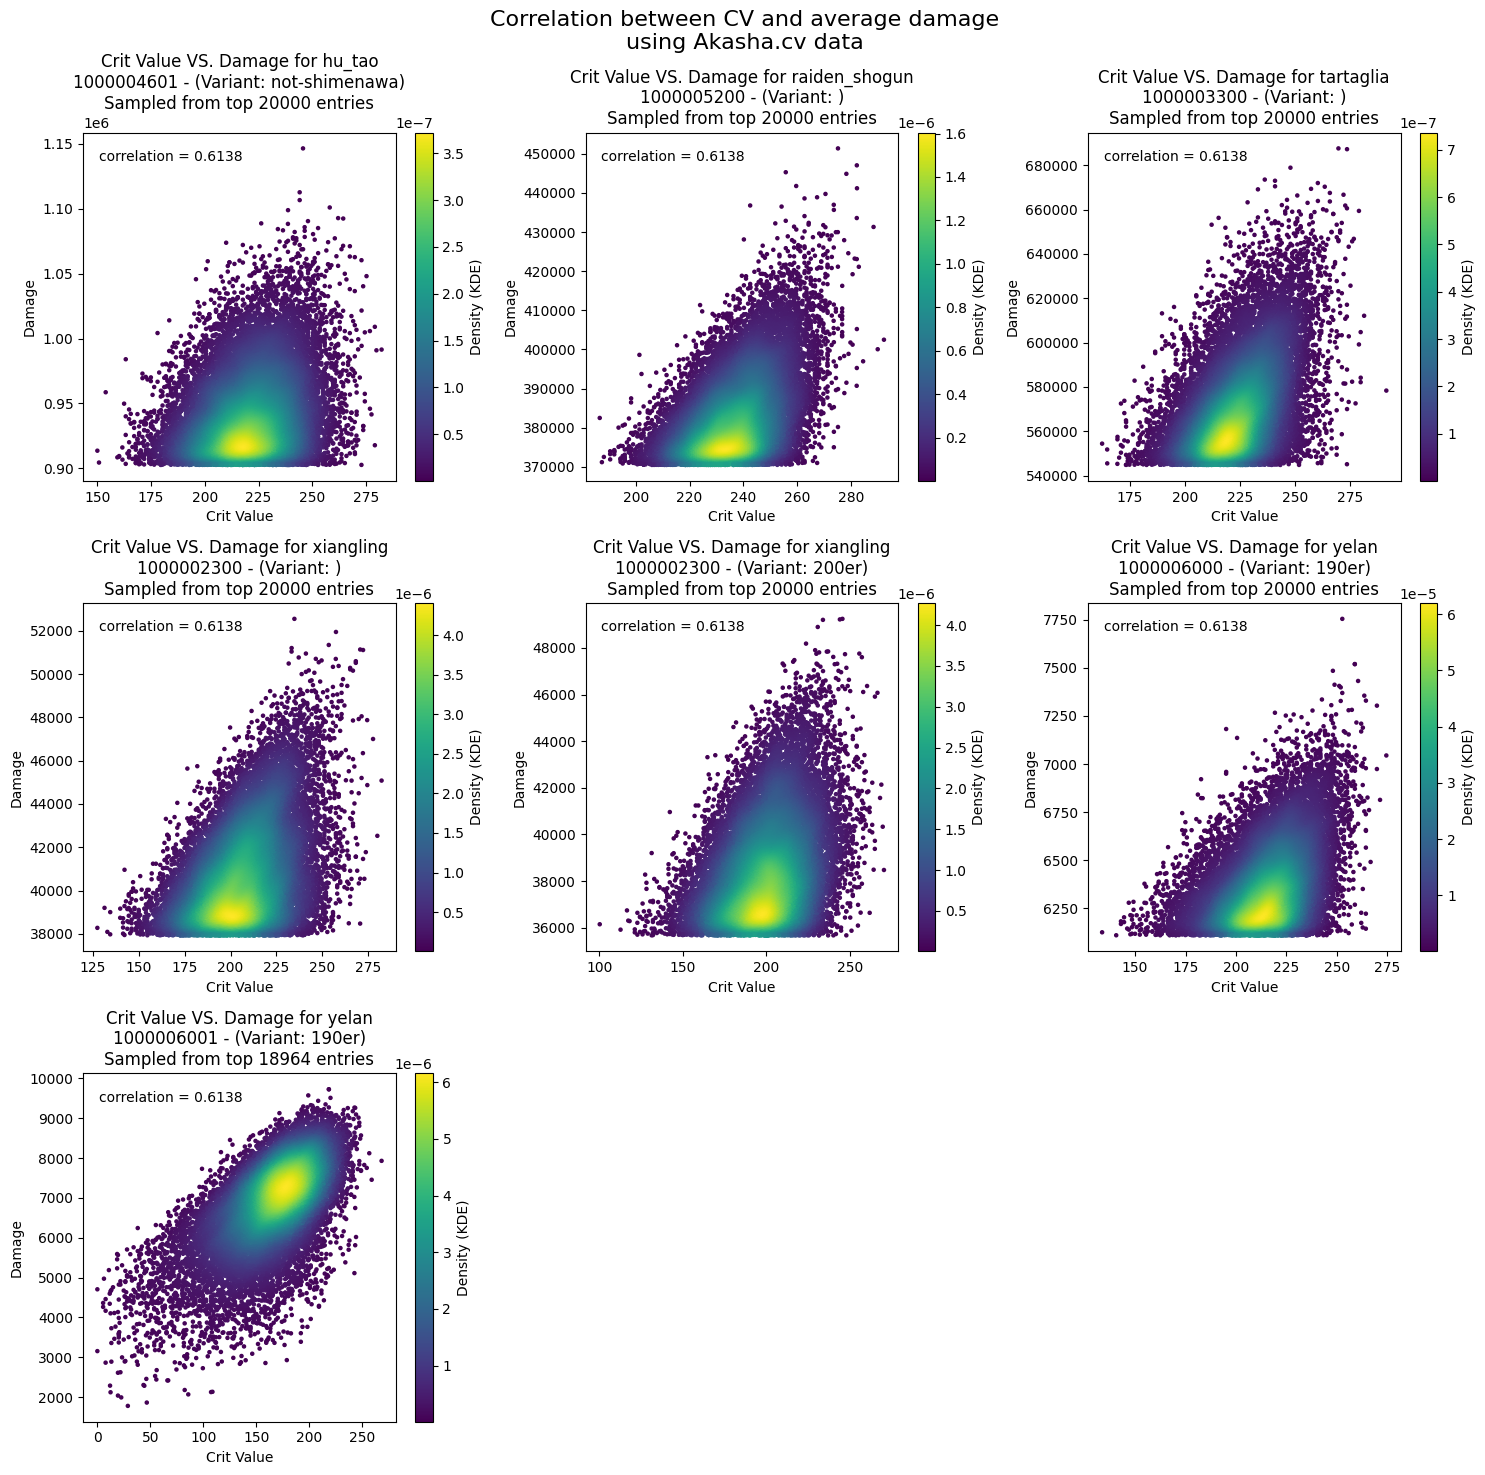

In [49]:
list = []
for (name, calculation_id, variant), group in groups:

    corr = group["crit_value"].corr(group["calculation_result"])

    def add_anotation(_, ax, plot):
         # Correlation coefficient
        ax.annotate(f'correlation = {corr:.4f}',
            (0.05, 0.95),
            xycoords='axes fraction',
            ha='left',
            va='top')

        plt.colorbar(plot, label='Density (KDE)')

    list.append(plot_sub(
        group, 
        "crit_value", 
        "calculation_result",
        label_x="Crit Value",
        label_y="Damage",
        title=f"Crit Value VS. Damage for {name}\n{calculation_id} - (Variant: {variant})\nSampled from top {len(group)} entries",
        mapfn=add_anotation
    ))
plot_scatter(list, 3, "Correlation between CV and average damage\nusing Akasha.cv data")
